<a href="https://colab.research.google.com/github/martinpius/MachineTranslation/blob/main/Wavenets_for_Language_Generations_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from timeit import default_timer as timer
t1= timer()
try:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  import torch, math, random
  import torch.nn.functional as F
  import matplotlib.pyplot as plt
  from tqdm.auto import tqdm
  print(f">>>> You are on CoLaB with torch version: {torch.__version__}")
except Exception as e:
  print(f">>>> {type(e)}: {e}\n>>>> Please correct {type(e)} and reload your drive")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
BATCH_SIZE = 128 if device == torch.device("cuda") else 64
print(f">>>> Available device: {device}")
def mytimer(t: float = timer())->float:
  h = int(t / (60 * 60))
  m = int(t % (60 * 60) / 60)
  s = int(t % 60)
  return f"hrs: {h:04}, mins: {m:>02}, secs: {s:>05.2f}"
print(f">>>> Time elapsed:\t {mytimer(timer() - t1)}")


Mounted at /content/drive/
>>>> You are on CoLaB with torch version: 2.0.1+cu118
>>>> Available device: cpu
>>>> Time elapsed:	 hrs: 0000, mins: 00, secs: 37.00


In [65]:
class Linear:

  def __init__(self, in_dim, out_dim, bias = True):
    self.weight = torch.randn(size = (in_dim, out_dim), generator = g) * (in_dim) ** -0.5
    self.bias = torch.zeros(out_dim) if bias else None

  def __call__(self, x: torch.Tensor)->torch.Tensor:
    self.out = torch.mm(x, self.weight)
    if self.bias is not None:
      self.out += self.bias
    else:
      self.out = self.out
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  
class CatEmbedding:

  def __init__(self, in_dim, em_dim):
    self.weight = torch.randn(size = (in_dim, em_dim), generator = g)
  
  def __call__(self, IX: torch.Tensor)->torch.Tensor:
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

class Flatten:

  def __call__(self, x: torch.Tensor)->torch.Tensor:
    B, T, C = x.shape
    x = x.view(B, -1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Tanh: 
  
  def __call__(self, x: torch.Tensor)->torch.Tensor:
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

class BatchNorm1d:

  def __init__(self, dim, eps = 1e-5, momentum = 0.1):

    self.betta = torch.zeros(dim)
    self.gamma = torch.ones(dim)
    self.training = True
    self.rn_mean = torch.zeros(dim)
    self.rn_var = torch.ones(dim)
    self.momentum = momentum
    self.eps = eps
  
  def __call__(self, x: torch.Tensor)->torch.Tensor:

    if self.training:
      bn_mean = x.mean(dim = 0, keepdims = True)
      bn_var = x.var(dim = 0, keepdims = True)
    else:
      bn_mean = self.rn_mean
      bn_var = self.rn_var
    
    bn_raw = (x - bn_mean) / torch.sqrt(bn_var + self.eps)
    self.out = self.gamma * bn_raw + self.betta

    if self.training:
      with torch.no_grad():
        self.rn_mean = (1 - self.momentum) * self.rn_mean + self.momentum * bn_mean
        self.rn_var = (1 - self.momentum) * self.rn_var + self.momentum * bn_var

    return self.out
  
  def parameters(self):
    return [self.betta, self.gamma]

class Sequential:
  
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x: torch.Tensor)->torch.Tensor:
    for layer in self.layers:
      x = layer(x)
      self.out = x
    return self.out
  
  def parameters(self):
    return []


In [66]:
file_path = "/content/drive/MyDrive/Language models/makemore-master/names.txt"
names = open(file_path, "r").read().splitlines()
chars = sorted(list(set("".join(names))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

def wavenetDataset(n_list):

  X, Y = [], []
  block_size = 8

  for name in n_list:
    context = [0] * block_size
    for ch in name + ".":
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      context = context[1:] + [idx]
  X, Y = torch.tensor(X), torch.tensor(Y)
  return X, Y

random.seed(1234)
random.shuffle(names)
n1, n2 = int(0.8 * len(names)), int(0.9 * len(names))
X_tr, Y_tr = wavenetDataset(names[:n1])
X_dv, Y_dv = wavenetDataset(names[n1:n2])
X_ts, Y_ts = wavenetDataset(names[n2:])

print(f">>>> X_tr shape: {X_tr.shape}, Y_tr shape: {Y_tr.shape}\
\n>>>> X_dv shape: {X_dv.shape}, Y_dv shape: {Y_dv.shape}\
\n>>>> X_ts shape: {X_ts.shape}, Y_ts shape: {Y_ts.shape}")

>>>> X_tr shape: torch.Size([182542, 8]), Y_tr shape: torch.Size([182542])
>>>> X_dv shape: torch.Size([22823, 8]), Y_dv shape: torch.Size([22823])
>>>> X_ts shape: torch.Size([22781, 8]), Y_ts shape: torch.Size([22781])


In [67]:
g = torch.Generator().manual_seed(1234)
in_dim, out_dim = len(stoi), len(itos)
seq_len = 8
em_dim = 10
h_dim = 200


In [68]:
layers = [CatEmbedding(in_dim, em_dim), Flatten(), Linear(em_dim * seq_len, h_dim),
          BatchNorm1d(h_dim), Tanh(),
          Linear(h_dim, h_dim), BatchNorm1d(h_dim), Tanh(),
          Linear(h_dim, h_dim), BatchNorm1d(h_dim), Tanh(),
          Linear(h_dim, h_dim), BatchNorm1d(h_dim), Tanh(),
          Linear(h_dim, h_dim), BatchNorm1d(h_dim), Tanh(),
          Linear(h_dim, out_dim), BatchNorm1d(out_dim)]

with torch.no_grad():
  layers[-2].weight *= 0.1

  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5 / 8

In [69]:
print(f">>>> Total number of learnable parameters in the ntwork is: {sum(p.numel() for l in layers for p in l.parameters()):,}")

>>>> Total number of learnable parameters in the ntwork is: 184,751


In [70]:
model = Sequential(layers)

In [72]:
EPOCHS = 100000
losses = []
steps = []

In [73]:
params = [p for l in model.layers for p in l.parameters()]
for p in params:
  p.requires_grad = True

In [74]:
tic = timer()
for epoch in tqdm(range(EPOCHS)):
  ix = torch.randint(low = 0, high = len(X_tr), size = (BATCH_SIZE,))
  xbatch, ybatch = X_tr[ix], Y_tr[ix]
  # Forward pass:
  logits = model(xbatch)

  # loss
  tr_loss = F.cross_entropy(logits, ybatch)
  # if epoch % 1000 == 0:
  #   print(f">>>> Epoch: {epoch + 1 if epoch == 0 else epoch}: Train Loss: {tr_loss.item():.4f}")
  
  for p in params:
    p.grad = None

  tr_loss.backward() # Pytorch auto-grad

  LR = 0.1 if epoch < 60000 else 0.01
  # stochastic gradient descent
  for p in params:
    p.data += -LR * p.grad 
  losses.append(tr_loss.item())
  steps.append(epoch)


  0%|          | 0/100000 [00:00<?, ?it/s]

>>>> Average training loss achieved: 1.8774
>>>> Total time elapsed: hrs: 0000, mins: 14, secs: 37.00


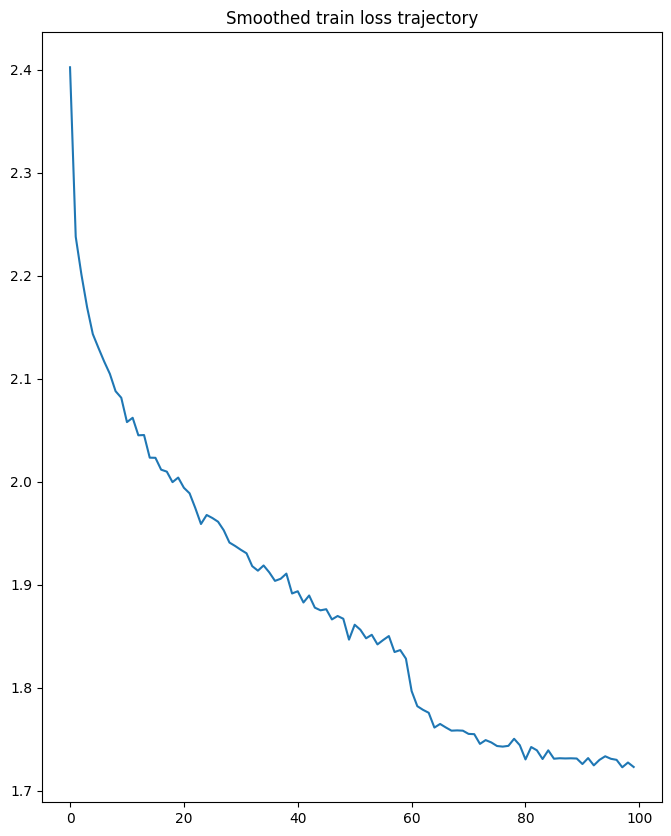

In [75]:
plt.figure(figsize = (8, 10))
sm_losses = torch.tensor(losses).view(-1, 1000).mean(dim = 1)
plt.plot(sm_losses)
plt.title("Smoothed train loss trajectory")
print(f">>>> Average training loss achieved: {torch.tensor(losses).mean():.4f}")
toc = timer()
print(f">>>> Total time elapsed: {mytimer(toc - tic)}")

In [76]:
for layer in model.layers:
  layer.training = False

In [77]:
with torch.no_grad():
  logits_v = model(X_dv)
  val_loss = F.cross_entropy(logits_v, Y_dv)
  logits_t = model(X_ts)
  ts_loss = F.cross_entropy(logits_t, Y_ts)
  print(f">>>> Validation Loss is: {val_loss.item():.4f}\
  \n>>>> Testing loss is: {ts_loss.item():.4f}")


>>>> Validation Loss is: 2.0042  
>>>> Testing loss is: 2.0264


In [78]:
# Sampling from the network:
for _ in range(30):
  out = []
  context = [0]* seq_len
  while True:
    model.training = False
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim = 1)
    ix = torch.multinomial(input = probs, num_samples = 1).item()
    context = context[1:] + [ix]
    out.append(itos[ix])
    if ix == 0:
      break
  print(f">>>> Generated name : {''.join(out)}")


>>>> Generated name : feyton.
>>>> Generated name : ridgen.
>>>> Generated name : sincon.
>>>> Generated name : karolon.
>>>> Generated name : dwayk.
>>>> Generated name : noop.
>>>> Generated name : jozlyn.
>>>> Generated name : jaseen.
>>>> Generated name : uliva.
>>>> Generated name : presleigh.
>>>> Generated name : azaylynn.
>>>> Generated name : aldin.
>>>> Generated name : emmy.
>>>> Generated name : meilin.
>>>> Generated name : cyriselah.
>>>> Generated name : ateela.
>>>> Generated name : ryler.
>>>> Generated name : emetty.
>>>> Generated name : landri.
>>>> Generated name : thanna.
>>>> Generated name : hayleen.
>>>> Generated name : princessl.
>>>> Generated name : jephellne.
>>>> Generated name : jin.
>>>> Generated name : arell.
>>>> Generated name : christopher.
>>>> Generated name : gwendolere.
>>>> Generated name : malajuh.
>>>> Generated name : barasey.
>>>> Generated name : adriemay.


In [84]:
model = Sequential(layers)

In [85]:
#model1 = Sequential(layers1)

In [86]:
for layer in model.layers:
  print(f">>>> {layer.__class__.__name__}: {tuple(layer.out.shape)}")

>>>> CatEmbedding: (1, 8, 10)
>>>> Flatten: (1, 80)
>>>> Linear: (1, 200)
>>>> BatchNorm1d: (1, 200)
>>>> Tanh: (1, 200)
>>>> Linear: (1, 200)
>>>> BatchNorm1d: (1, 200)
>>>> Tanh: (1, 200)
>>>> Linear: (1, 200)
>>>> BatchNorm1d: (1, 200)
>>>> Tanh: (1, 200)
>>>> Linear: (1, 200)
>>>> BatchNorm1d: (1, 200)
>>>> Tanh: (1, 200)
>>>> Linear: (1, 200)
>>>> BatchNorm1d: (1, 200)
>>>> Tanh: (1, 200)
>>>> Linear: (1, 27)
>>>> BatchNorm1d: (1, 27)
